# Assignment 5
Student: Ilia Kamyshev

## Min vol ellipsoid

As in slides, the center of an ellipsoid covering two given sets is: $x_c=-\frac{1}{1+n}\frac{P_0w}{\sqrt{w^TP_0w}}$ and its parameters matrix $P=\frac{n^2}{n^2-1}(P_0-\frac{2P_0ww^TP_0}{(n+1)w^TP_0w})$

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

Given $P_0$

In [2]:
pmat0 = np.array([[1, 0], [0, 4]])

Computing matrix $P$ and center of ellipsoid $x_c$:

In [3]:
def get_pmatrix(pmat0, n, w):
    return (
        n ** 2
        / (n ** 2 - 1)
        * (pmat0 - 2 / (n + 1) * pmat0 @ w @ w.T @ pmat0 / (w.T @ pmat0 @ w))
    )


def get_center(pmat0, n, w):
    return -1 / (n + 1) * pmat0 @ w / np.sqrt(w.T @ pmat0 @ w)

Thus from ellipsoid equation $(x-x_c)^TP^{-1}(x-x_c)$ we will have:

In [4]:
def ellipse(x, y, xc, pmat):
    xc = xc.ravel()
    p = np.linalg.inv(pmat)

    cx = xc[0]
    cy = xc[1]

    return (
        (x - cx) ** 2 * p[0, 0]
        + (y - cy) ** 2 * p[1, 1]
        + (x - cx) * (y - cy) * (p[1, 0] + p[0, 1])
        - 1
    )

**Case 1**

In [5]:
w = np.array([[1], [0]])
n = len(w)

pmat = get_pmatrix(pmat0, n, w)
xc = get_center(pmat0, n, w)
w = w.ravel()

print("P=\n", pmat, "\n")
print("xc=\n", xc)

P=
 [[0.44444444 0.        ]
 [0.         5.33333333]] 

xc=
 [[-0.33333333]
 [ 0.        ]]


The volume of ellipsoid in our case is $vol(\epsilon)=\det P^{-1/2}$

In [6]:
vol = np.linalg.det(np.linalg.inv(pmat)) ** 0.5
vol0 = np.linalg.det(np.linalg.inv(pmat0)) ** 0.5
print("Ratio =", np.round(vol / vol0, 4))

Ratio = 1.299


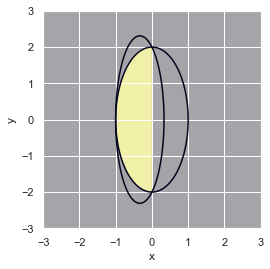

In [7]:
lim = 3
x, y = np.meshgrid(np.linspace(-lim, lim, 1000), np.linspace(-lim, lim, 1000))

plt.imshow(
    (
        (ellipse(x, y, xc, pmat) <= 0)
        & (ellipse(x, y, 0 * xc, pmat0) <= 0)
        & (w[0] * x + w[1] * y <= 0)
    ).astype(int),
    extent=(x.min(), x.max(), y.min(), y.max()),
    origin="lower",
    cmap="gnuplot",
    alpha=0.3,
)

plt.contour(x, y, ellipse(x, y, xc, pmat), [0])
plt.contour(x, y, ellipse(x, y, 0 * xc, pmat0), [0])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

**Case 2**

In [8]:
w = np.array([[1 / 2], [-1 / 2]])
n = len(w)

pmat = get_pmatrix(pmat0, n, w)
xc = get_center(pmat0, n, w)
w = w.ravel()

print("P=\n", pmat, "\n")
print("xc=\n", xc)

P=
 [[1.15555556 0.71111111]
 [0.71111111 2.48888889]] 

xc=
 [[-0.1490712 ]
 [ 0.59628479]]


In [9]:
vol = np.linalg.det(np.linalg.inv(pmat)) ** 0.5
print("Ratio =", np.round(vol / vol0, 4))

Ratio = 1.299


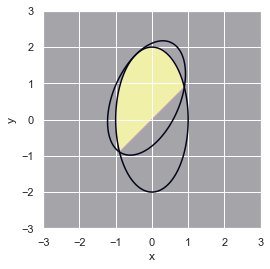

In [10]:
plt.imshow(
    (
        (ellipse(x, y, xc, pmat) <= 0)
        & (ellipse(x, y, 0 * xc, pmat0) <= 0)
        & (w[0] * x + w[1] * y <= 0)
    ).astype(int),
    extent=(x.min(), x.max(), y.min(), y.max()),
    origin="lower",
    cmap="gnuplot",
    alpha=0.3,
)

plt.contour(x, y, ellipse(x, y, xc, pmat), [0])
plt.contour(x, y, ellipse(x, y, 0 * xc, pmat0), [0])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Schur complement

From ellipsoid we have: $1-(x-c)^TP^{-1}(x-c)\geq0$
Thus, from complement $C-B^TA^{-1}B\succ0\implies C=1,B=(x-c),A=P$. Now for $x=a$ we have:
$X\succeq0\implies\begin{bmatrix}
P & a-c\\
(a-c)^T & 1
\end{bmatrix}\succeq0$. Here we can take only this complement $(A\succ0)$ since for ellipsoid $P\succ0$

## Goemans-Willamson relaxation

In [11]:
from networkx.drawing.nx_pylab import draw
from networkx.linalg.laplacianmatrix import laplacian_matrix
from networkx.generators.random_graphs import gnp_random_graph

In [12]:
import cvxpy as cp
from scipy.linalg import cholesky

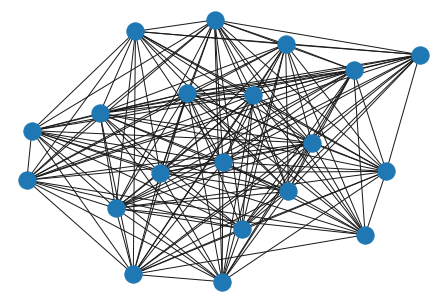

In [13]:
# Dimension
n = 20
# Proba of eedge creation
p = 0.9
# Graph
g = gnp_random_graph(n, p)
# Add weights from uniform distributtion
for (u, v, w) in g.edges(data=True):
    w["weight"] = np.random.rand()
draw(g)

Laplacian matrix of the graph $L$

In [14]:
# Laplacian matrix
lmat = laplacian_matrix(g).toarray()

In [15]:
print("Share of non-zero elements =", np.count_nonzero(lmat) / lmat.size)

Share of non-zero elements = 0.89


The problem is to maximize given $\text{Tr}(LX)$ subject to $X_{ii}=1$

In [16]:
# Matrix variable
xmat = cp.Variable((n, n), PSD=True)
# Constraints for trace maxinization
constraints = [xmat[i, i] == 1 for i in range(n)]
problem = cp.Problem(cp.Maximize(cp.trace(lmat @ xmat)), constraints)
problem.solve(solver="CVXOPT")
# Optimal solution
xval = xmat.value
# Optimal value
maxval = problem.value
print("The optimal value is", np.round(problem.value,4))

The optimal value is 209.9063


Cholesky decomposition:

In [17]:
vmat = cholesky(xval)

Visualization

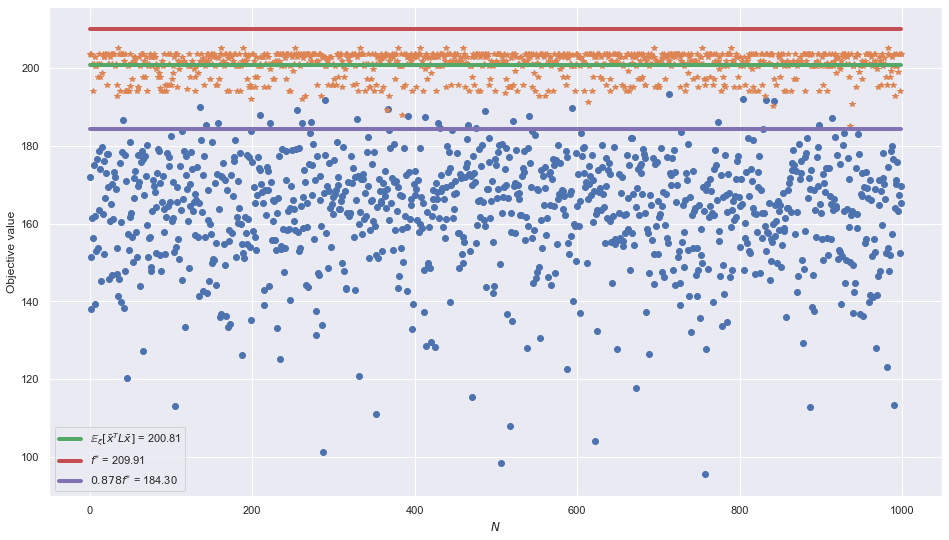

In [18]:
# Number of samples
s = 1000
# Naive randomization
x = np.random.randint(2, size=(s, n))
x[x == 0] = -1
# For Goemans relaxation
xi = np.random.randn(s, n)

goemans = []
objectives = []
for i in range(s):
    # Sample of `x`
    _x = x[i].reshape(-1, 1)
    # Sample of `xi`
    _xi = xi[i].reshape(-1, 1)
    _xi /= np.linalg.norm(_xi, ord=2)

    # Compute x with bar
    xbar = np.sign(vmat.T @ _xi)
    # Its objective value
    fxbar = xbar.T @ lmat @ xbar
    goemans.append(fxbar.item())

    # Objective value for naive randomization
    fx = _x.T @ lmat @ _x
    objectives.append(fx.item())

plt.figure(figsize=(16, 9))
plt.plot(range(s), objectives, "o")
plt.plot(range(s), goemans, "*")
plt.plot(
    range(s),
    [np.mean(goemans)] * s,
    linewidth=4,
    label=r"$\mathbb{E}_{\xi}[\bar{x}^TL\bar{x}]$ = %.2f" % np.mean(goemans),
)
plt.plot(range(s), [maxval] * s, linewidth=4, label=r"$f^{*}$ = %.2f" % maxval)
plt.plot(
    range(s),
    [0.878 * maxval] * s,
    linewidth=4,
    label=r"$0.878f^{*}$ = %.2f" % (0.878 * maxval),
)
plt.xlabel(r"$N$")
plt.ylabel("Objective value")
plt.legend()
plt.show()

## Capital

This problem can be stated as $\text{max}\ c^Tw$ subject to $Ax\leq b$, $w\geq0$ and weights proportion (described below). Where $c$ vector of profits per each cargo, $w$ is distributed weights (tonnes) of each cargo over each section of a plane (4 cargo for 3 sections). The constraints are came from the table given in the assignment, and they are following:

In [19]:
amat = np.array(
    [
        # Weight capacity per each section
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        # Space capacity per each section
        [480, 650, 580, 390, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 480, 650, 580, 390, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 480, 650, 580, 390],
        # Existance constraints (total weight of each cargo is limited)
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
    ]
)
# Corresponding vector `x`
b = np.array([[10], [16], [8], [6800], [8700], [5300], [18], [15], [23], [12],])

In [20]:
print("We have",amat.shape[0],"inequality constraints")

We have 10 inequality constraints


In [21]:
amat

array([[  1,   1,   1,   1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   1,   1,   1,   1,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   1,   1],
       [480, 650, 580, 390,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 480, 650, 580, 390,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 480, 650, 580, 390],
       [  1,   0,   0,   0,   1,   0,   0,   0,   1,   0,   0,   0],
       [  0,   1,   0,   0,   0,   1,   0,   0,   0,   1,   0,   0],
       [  0,   0,   1,   0,   0,   0,   1,   0,   0,   0,   1,   0],
       [  0,   0,   0,   1,   0,   0,   0,   1,   0,   0,   0,   1]])

Profit vector

In [22]:
# Cost vector for each cargo
c = np.array(
    [
        [310],
        [380],
        [350],
        [285],
        [310],
        [380],
        [350],
        [285],
        [310],
        [380],
        [350],
        [285],
    ]
)

Here we made following assumptions:
* shape of cargo does not matter
* cargo can be divided arbitrary (by part of any size)

In [23]:
w = cp.Variable((len(c), 1))
# Weights are non-negative
constraints = [w[i] >= 0 for i in range(len(c))]
constraints += [amat @ w <= b]
# Proportion constraints
constraints += [16 * (w[0] + w[1] + w[2] + w[3]) == 10 * (w[4] + w[5] + w[6] + w[7])]
constraints += [8 * (w[0] + w[1] + w[2] + w[3]) == 10 * (w[8] + w[9] + w[10] + w[11])]

problem = cp.Problem(cp.Maximize(c.T @ w), constraints)
problem.solve(solver="CVXOPT")
# Optimal weights distribution
wval = np.round(w.value, 4)
print("w*=\n", wval, "\n")
# Mawimum profit
print("The maximum profit =", np.round(problem.value,4), "$")

w*=
 [[ 0.    ]
 [ 8.3288]
 [ 1.6712]
 [ 0.    ]
 [ 0.    ]
 [ 0.    ]
 [12.9474]
 [ 3.0526]
 [ 0.    ]
 [ 6.6712]
 [ 1.3288]
 [ 0.    ]] 

The maximum profit = 12151.5789 $


In [24]:
print("Cargo 1 used =", wval[0::4, 0].sum(), "out of", 18)
print("Cargo 2 used =", wval[1::4, 0].sum(), "out of", 15)
print("Cargo 3 used =", wval[2::4, 0].sum(), "out of", 23)
print("Cargo 4 used =", wval[3::4, 0].sum(), "out of", 12)

Cargo 1 used = 0.0 out of 18
Cargo 2 used = 15.0 out of 15
Cargo 3 used = 15.9474 out of 23
Cargo 4 used = 3.0526 out of 12


Cargo 1 was not used, while the cargo 2 was the only one on full-load, therefore it influences more than the others.

In [25]:
w = cp.Variable((len(c), 1))
_b=b.copy()
_b[-4:] = 1.1 * b[-4:]
# Weights are non-negative
constraints = [w[i] >= 0 for i in range(len(c))]
constraints += [amat @ w <= _b]
# Proportion constraints
constraints += [16 * (w[0] + w[1] + w[2] + w[3]) == 10 * (w[4] + w[5] + w[6] + w[7])]
constraints += [8 * (w[0] + w[1] + w[2] + w[3]) == 10 * (w[8] + w[9] + w[10] + w[11])]

problem = cp.Problem(cp.Maximize(c.T @ w), constraints)
problem.solve(solver="CVXOPT")
# Optimal weights distribution
wval = np.round(w.value, 4)
print("w*=\n", wval, "\n")
# Mawimum profit
print("The maximum profit =", np.round(problem.value,4), "$")

w*=
 [[ 0.    ]
 [ 9.0062]
 [ 0.9938]
 [ 0.    ]
 [ 0.    ]
 [ 0.    ]
 [12.9474]
 [ 3.0526]
 [ 0.    ]
 [ 6.9938]
 [ 1.0062]
 [ 0.    ]] 

The maximum profit = 12181.5789 $


In [26]:
print("Cargo 1 used =", wval[0::4, 0].sum(), "out of", 1.1 * 18)
print("Cargo 2 used =", wval[1::4, 0].sum(), "out of", 1.1 * 15)
print("Cargo 3 used =", wval[2::4, 0].sum(), "out of", 1.1 * 23)
print("Cargo 4 used =", wval[3::4, 0].sum(), "out of", 1.1 * 12)

Cargo 1 used = 0.0 out of 19.8
Cargo 2 used = 16.0 out of 16.5
Cargo 3 used = 14.9474 out of 25.3
Cargo 4 used = 3.0526 out of 13.200000000000001


Cargo 1 was not used again, while the cargo 2 has more total weight than any other, therefore it influences more than the others.

In [27]:
w = cp.Variable((len(c), 1))
_b=b.copy()
_b[-4:] = 0.9 * b[-4:]
# Weights are non-negative
constraints = [w[i] >= 0 for i in range(len(c))]
constraints += [amat @ w <= _b]
# Proportion constraints
constraints += [16 * (w[0] + w[1] + w[2] + w[3]) == 10 * (w[4] + w[5] + w[6] + w[7])]
constraints += [8 * (w[0] + w[1] + w[2] + w[3]) == 10 * (w[8] + w[9] + w[10] + w[11])]

problem = cp.Problem(cp.Maximize(c.T @ w), constraints)
problem.solve(solver="CVXOPT")
# Optimal weights distribution
wval = np.round(w.value, 4)
print("w*=\n", wval, "\n")
# Mawimum profit
print("The maximum profit =", np.round(problem.value,4), "$")

w*=
 [[ 0.    ]
 [ 8.4957]
 [ 1.5043]
 [ 0.    ]
 [ 0.    ]
 [ 0.    ]
 [12.9474]
 [ 3.0526]
 [ 0.    ]
 [ 4.5043]
 [ 3.4957]
 [ 0.    ]] 

The maximum profit = 12091.5789 $


In [28]:
print("Cargo 1 used =", wval[0::4, 0].sum(), "out of", 0.9 * 18)
print("Cargo 2 used =", wval[1::4, 0].sum(), "out of", 0.9 * 15)
print("Cargo 3 used =", wval[2::4, 0].sum(), "out of", 0.9 * 23)
print("Cargo 4 used =", wval[3::4, 0].sum(), "out of", 0.9 * 12)

Cargo 1 used = 0.0 out of 16.2
Cargo 2 used = 13.0 out of 13.5
Cargo 3 used = 17.947400000000002 out of 20.7
Cargo 4 used = 3.0526 out of 10.8


Cargo 1 was not used again, while the cargo 3 has more total weight than any other, therefore it influences more than the others.

Increase of total weight increases the total profit. Decrease do vice versa. This is due to the straight forward linear dependancy between profit and weights of each cargo $profit=c^Tw$.